# Домашнее задание 8
## Задание - Обучите нейронную сеть любой архитектуры на каком-то датасете, который не рассматривался на уроке.
Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.

Возьмём сеть архитектуры U-Net. И датасет Oxford-IIIT Pet Dataset с изображениями домашних животных.

Путём неимоверных усилий удалось запустить модель с "Животными"

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-gkv9x9ao
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-gkv9x9ao
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=4161be48a6b274c5be08e4c11fbcb72d1a86420a673bc02c7072276c181e8bc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-gshv_5e3/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20S186/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20S186/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [51]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [52]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

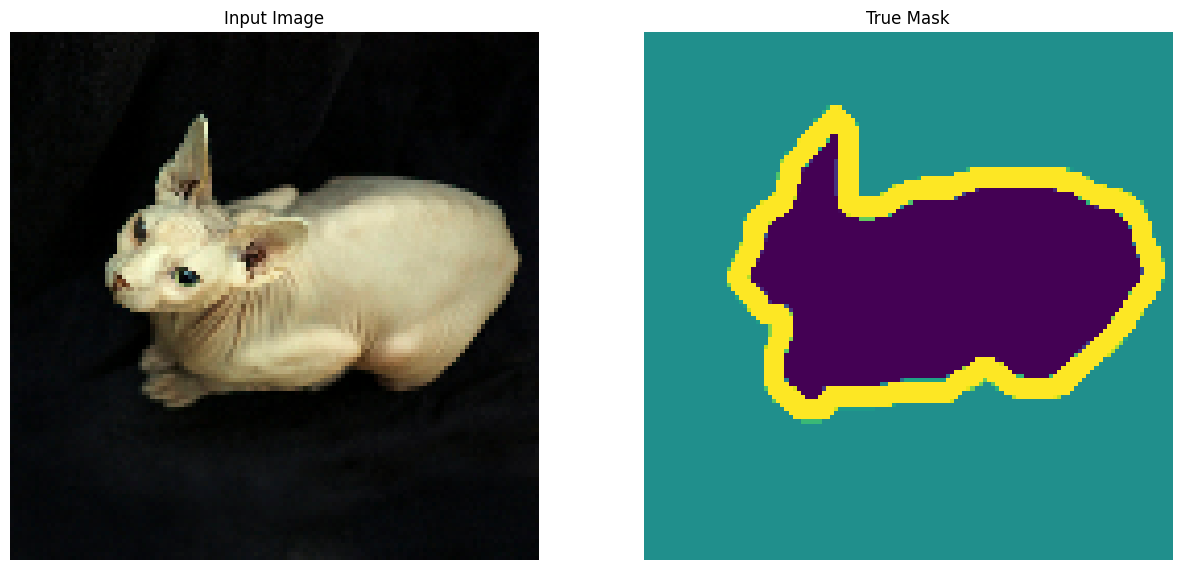

In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2. Декодером будет апсемпл блок, заранее имплементированный в TensorFlow examples Pix2pix tutorial.

In [8]:
OUTPUT_CHANNELS = 3

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
'block_1_expand_relu', # 64x64
'block_3_expand_relu', # 32x32
'block_6_expand_relu', # 16x16
'block_13_expand_relu', # 8x8
'block_16_project', # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 64x64
]
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs
    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same') #64x64 -> 128x128
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

С помощью модели попробуем сделать предсказание до того, как началось обучение.

1/1 [==============================] - 1s 1s/step


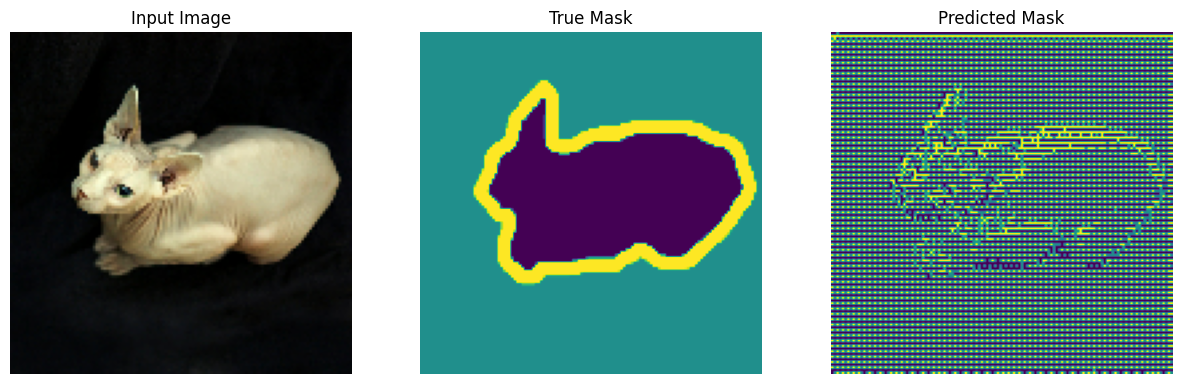

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [13]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Тренировка

1/1 [==============================] - 0s 65ms/step


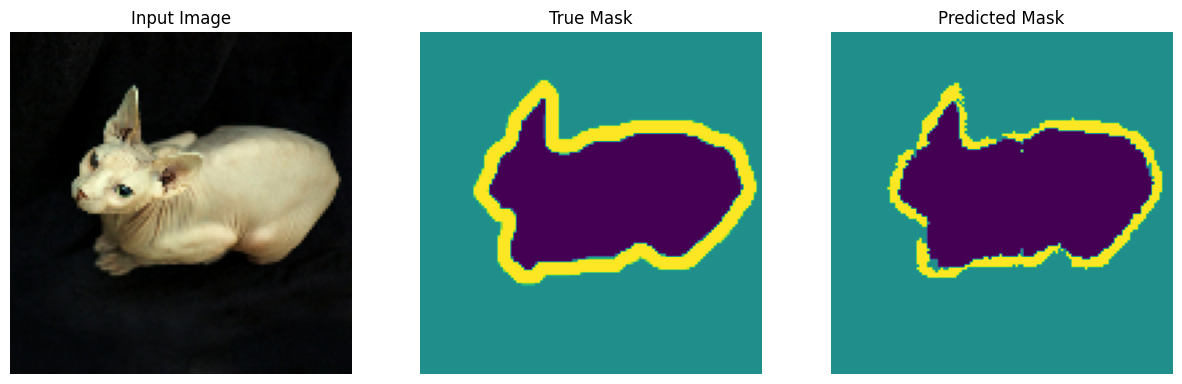


Sample Prediction after epoch 5

57/57 [==============================] - 317s 6s/step - loss: 0.2513 - accuracy: 0.8942 - val_loss: 0.2838 - val_accuracy: 0.8833


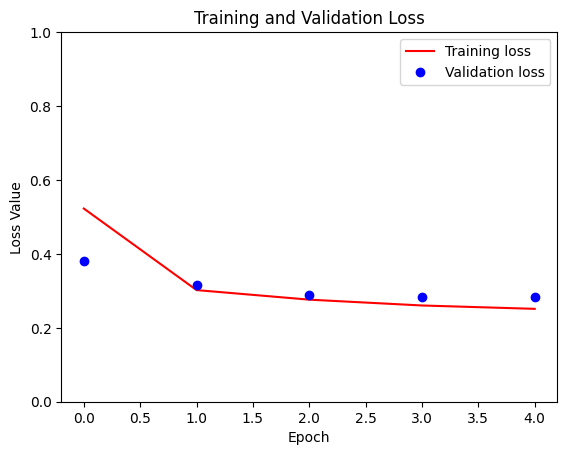

In [14]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Визуально на тренировочном примере сегментация довольно точна. Однако не смотря на то, что точность на тестовой выборке практически такая же, как и на тренировочной, на тестовых предсказаниях уже заметны значительные отклонения как границы, так и самой области сегментации, хотя образ всё же остаётся узнаваемым.<br>

2/2 [==============================] - 2s 936ms/step


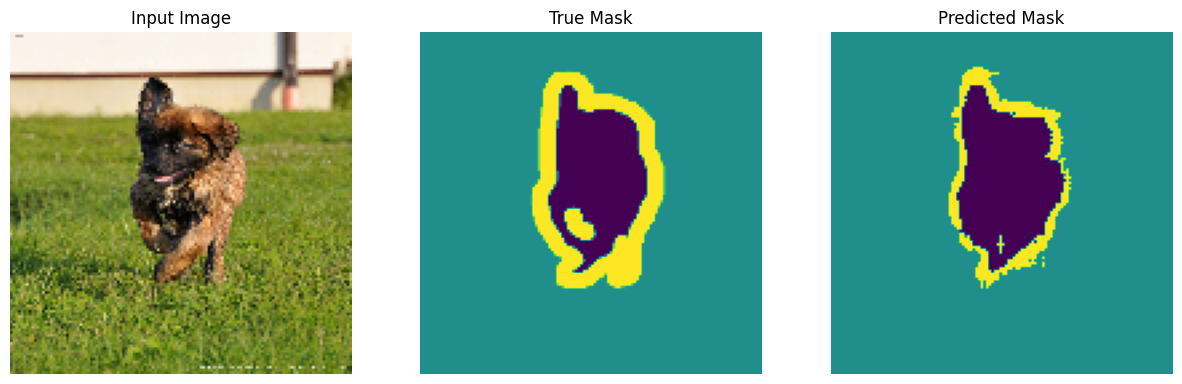

2/2 [==============================] - 2s 939ms/step


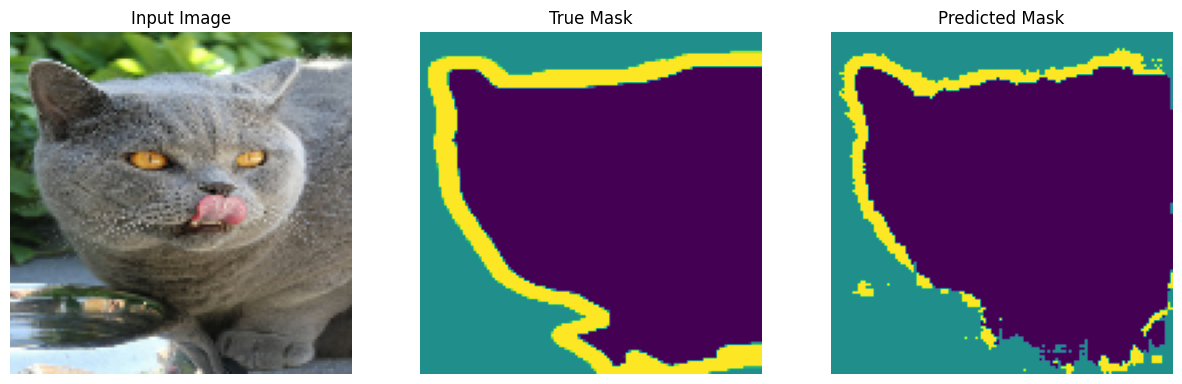

2/2 [==============================] - 3s 1s/step


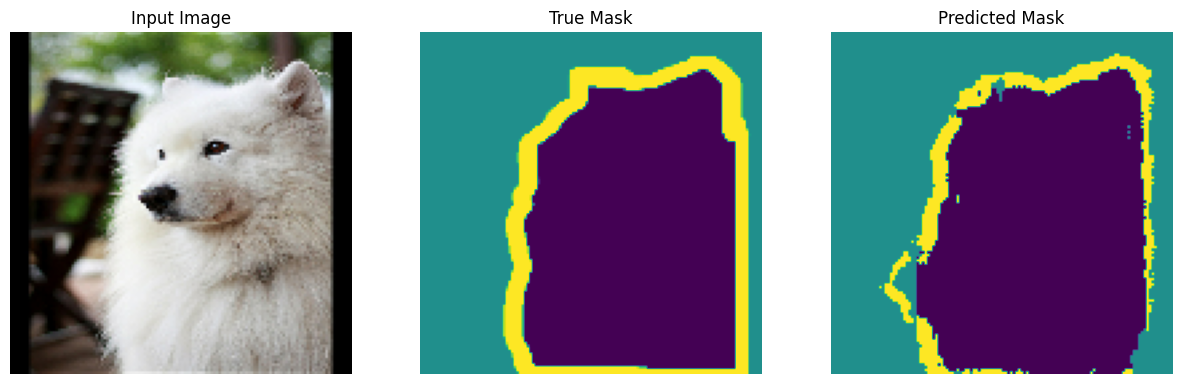

2/2 [==============================] - 2s 906ms/step


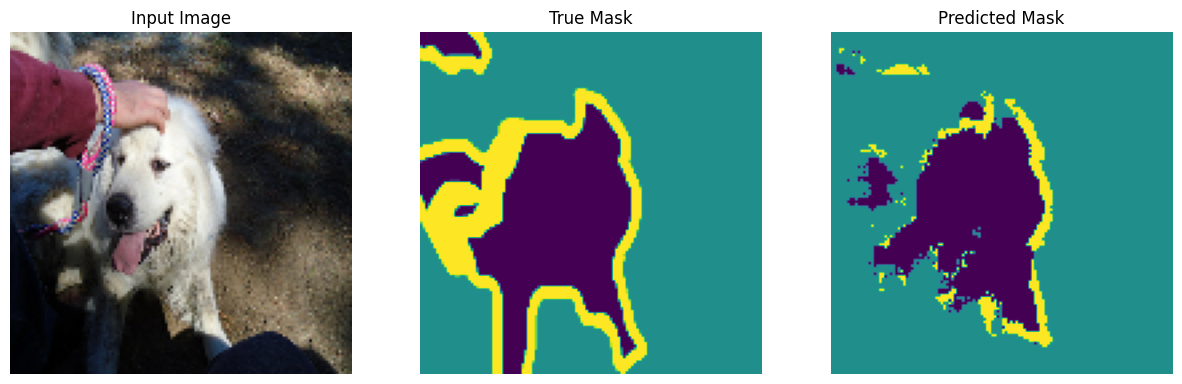

2/2 [==============================] - 2s 899ms/step


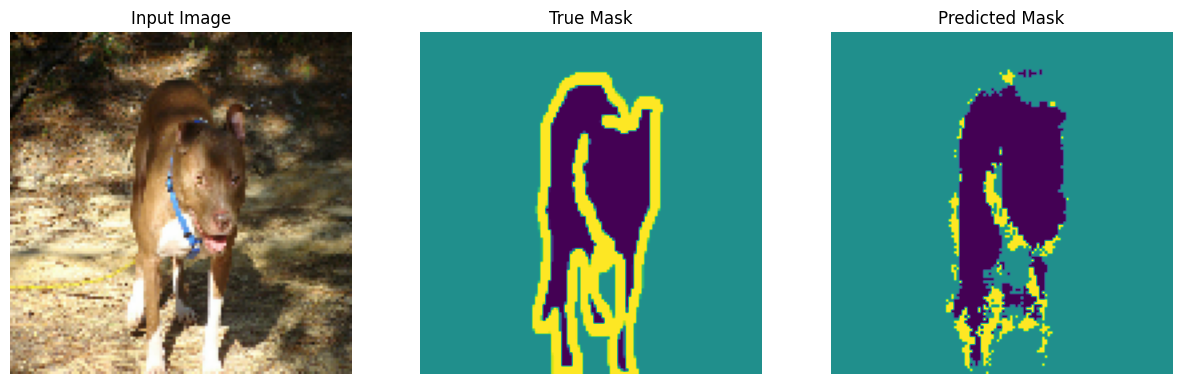

In [15]:
show_predictions(test_dataset, 5)

Посмотрим как обстоят дела на самой тренировочной вборке:

2/2 [==============================] - 2s 972ms/step


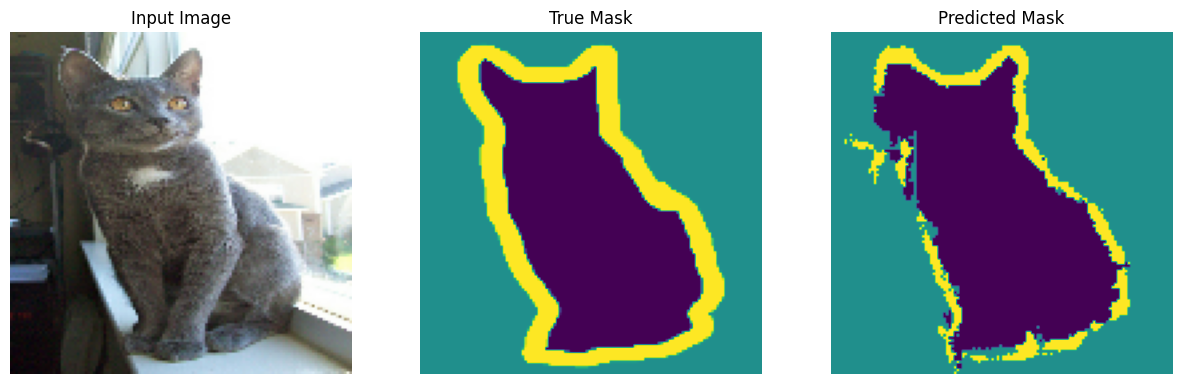

2/2 [==============================] - 3s 972ms/step


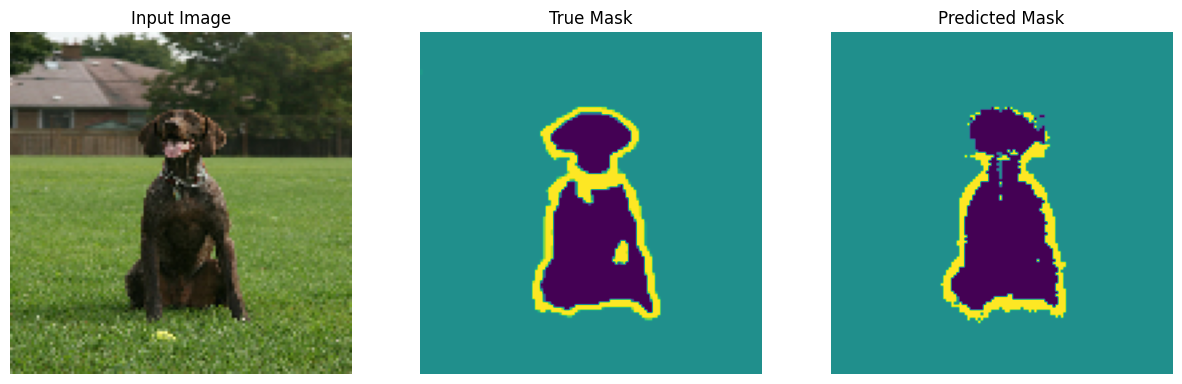

2/2 [==============================] - 2s 954ms/step


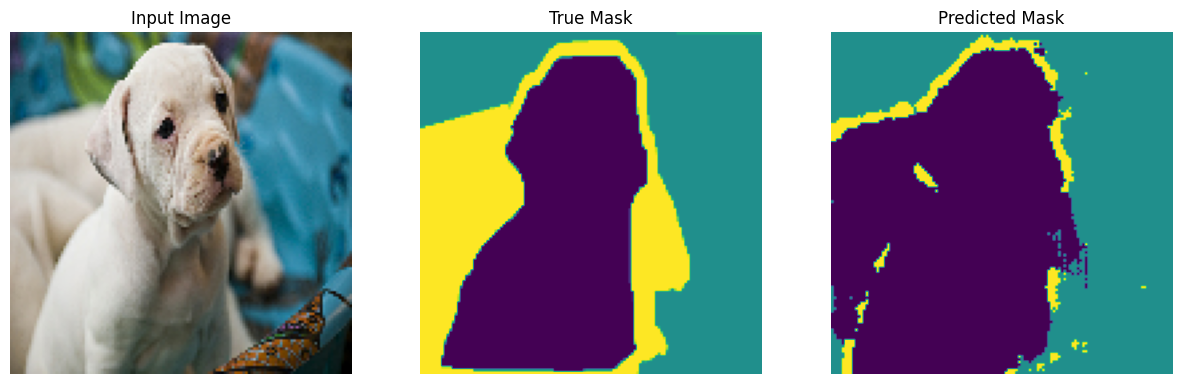

2/2 [==============================] - 2s 947ms/step


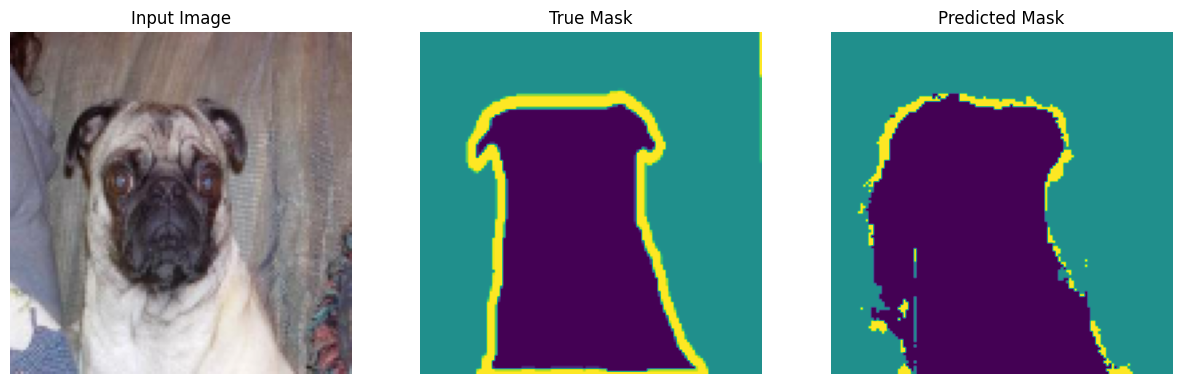

2/2 [==============================] - 3s 2s/step


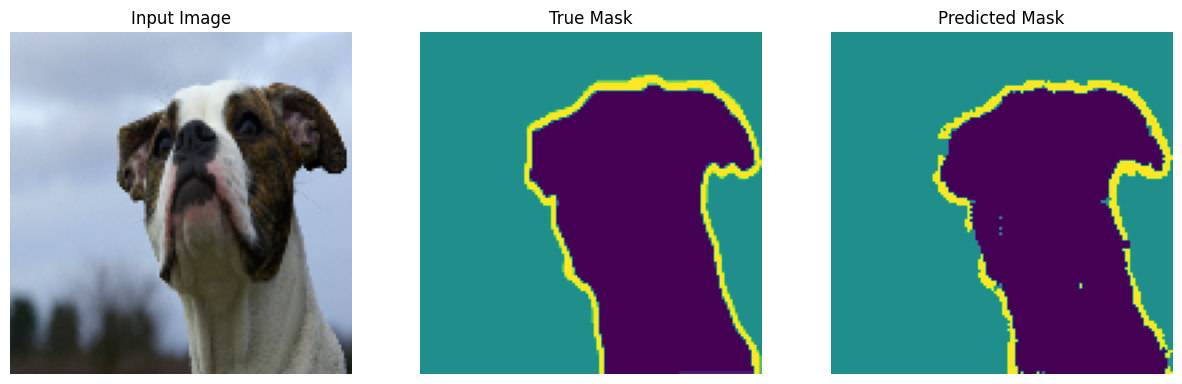

In [16]:
show_predictions(train_dataset, 5)

Визуально не на много, но всё же немного лучше, чем на тестовой выборке.<br>
Возможно при увеличении количества эпох - точность повысится.<br>
Сохраним натренированную на 5 эпохах модель.

In [18]:
model.save('animals')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


И проведём ещё 5 эпох обучения.

1/1 [==============================] - 0s 51ms/step


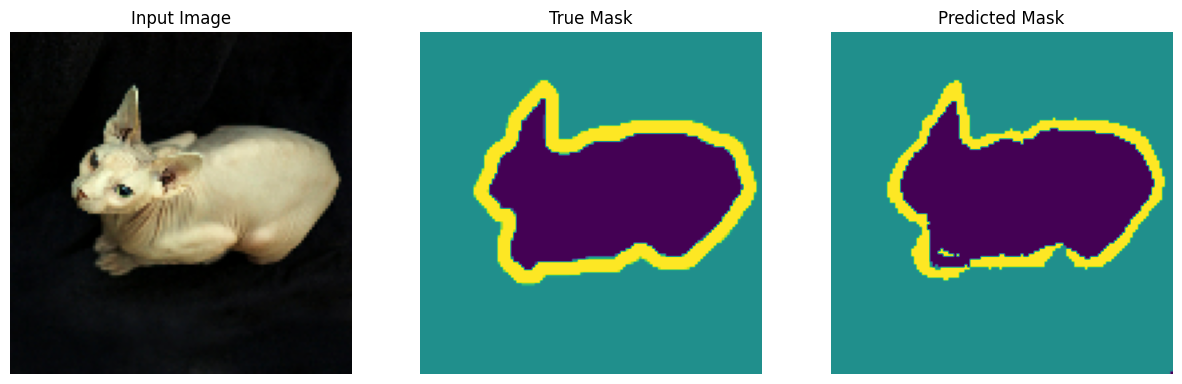


Sample Prediction after epoch 5

57/57 [==============================] - 315s 6s/step - loss: 0.2102 - accuracy: 0.9090 - val_loss: 0.2784 - val_accuracy: 0.8898


In [19]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()])

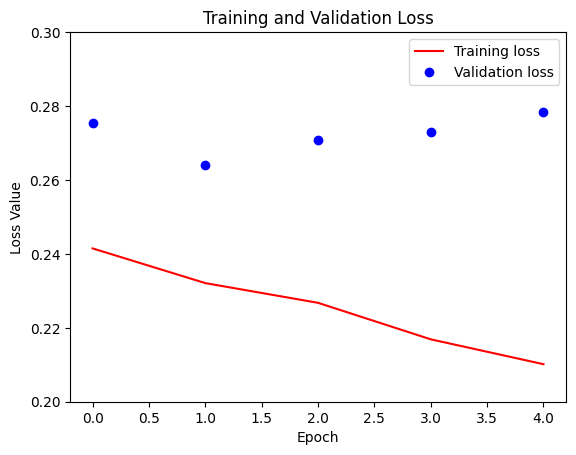

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0.2, 0.3])
plt.legend()
plt.show()

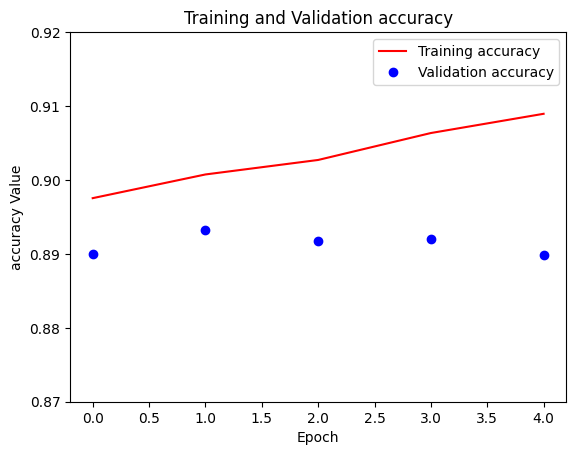

In [24]:
loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.ylim([0.87, 0.92])
plt.legend()
plt.show()

Не критично, но после седьмой эпохи (на графике это 1) наблюдается перетренированность.

2/2 [==============================] - 2s 874ms/step


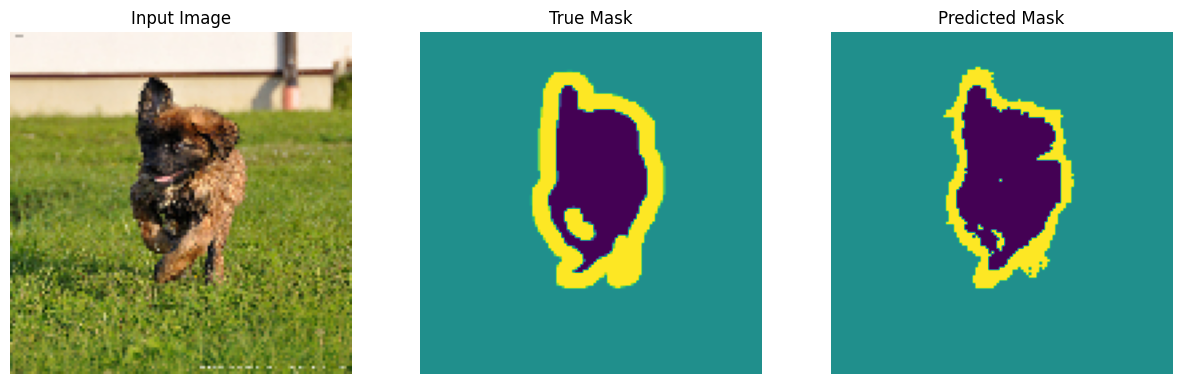

2/2 [==============================] - 2s 1s/step


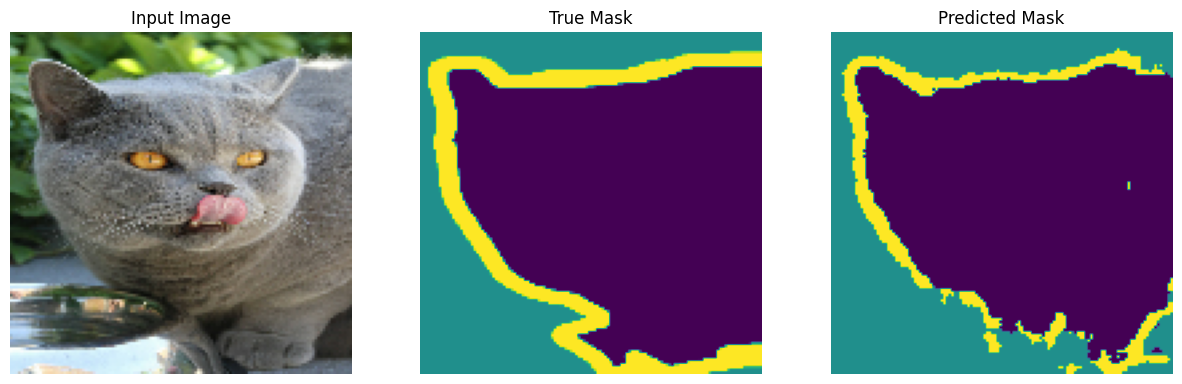

2/2 [==============================] - 2s 917ms/step


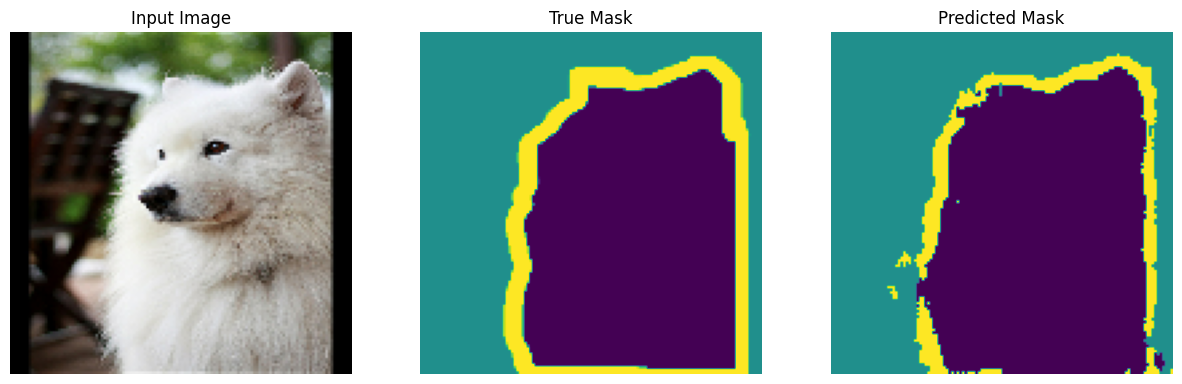

2/2 [==============================] - 2s 926ms/step


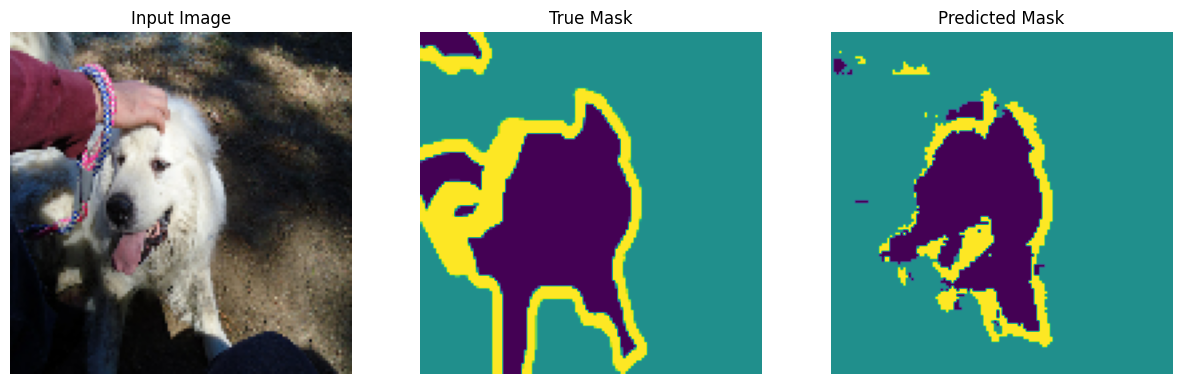

2/2 [==============================] - 2s 891ms/step


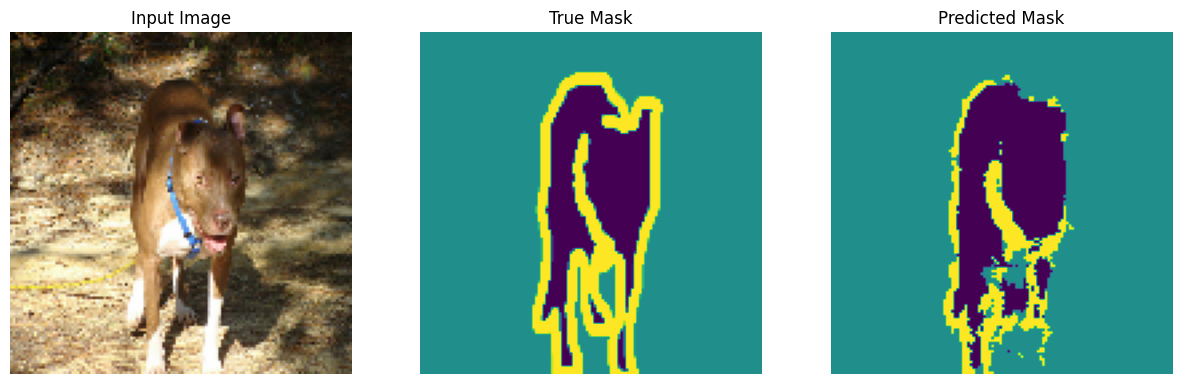

In [26]:
show_predictions(test_dataset, 5)

Визуально заметно, что предсказанные маски стали несколько точнее. Думаю, если вернуться к записанной модели и снова провести тренировку, но только на 2 эпохи - результат будет ещё немного лучше.

In [28]:
import keras

In [53]:
model_loaded = keras.models.load_model('animals')

In [30]:
model_history = model_loaded.fit(train_dataset, epochs=2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset)

Epoch 1/2
57/57 [==============================] - 294s 5s/step - loss: 0.2435 - accuracy: 0.8968 - val_loss: 0.2764 - val_accuracy: 0.8897
Epoch 2/2
57/57 [==============================] - 292s 5s/step - loss: 0.2323 - accuracy: 0.9006 - val_loss: 0.2798 - val_accuracy: 0.8874


Фокус не удался - результаты модели model_loaded получились хуже, чем у модели model. процесс обучения - достаточно случайный процесс. Можно поробовать заново дообучить модель.

In [ ]:
model_loaded = keras.models.load_model('animals')

In [54]:
model_history = model_loaded.fit(train_dataset, epochs=2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset)

Epoch 1/2
57/57 [==============================] - 327s 6s/step - loss: 0.2538 - accuracy: 0.8930 - val_loss: 0.2766 - val_accuracy: 0.8878
Epoch 2/2
57/57 [==============================] - 302s 5s/step - loss: 0.2410 - accuracy: 0.8975 - val_loss: 0.2670 - val_accuracy: 0.8926


Получили на тренировочной выборке результат хуже, а на тестовой лучше. Будем считать это оптимальным результатом для предсказания.

In [57]:
model.save('animals_optimal')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


Теперь вопрос - как подсунить в модель картинку для получения контура изображённого животного. Вероятно - это тема следующего курса "Сбор и разметка данных".